# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [676]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [14]:
noise = .2

#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

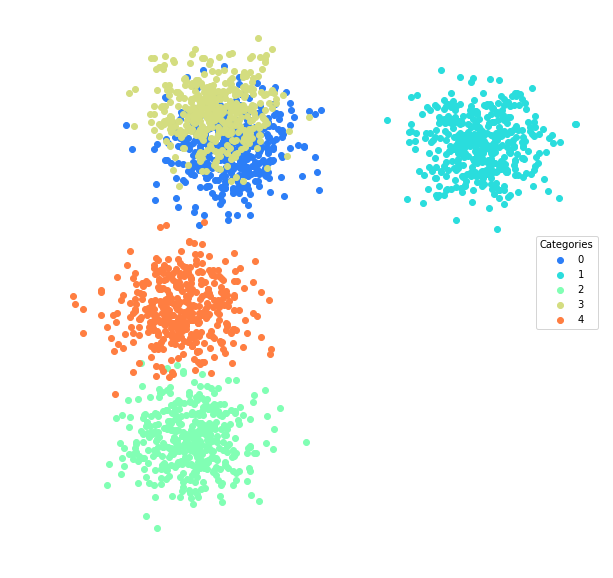

In [15]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [34]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [35]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [36]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.796398,0.530031,0.120,0.703297,0.659794
1,1.000000,1.000000,0.000,1.000000,1.000000
2,1.000000,1.000000,0.000,1.000000,1.000000
3,0.830922,0.580753,0.118,0.709091,0.742857
4,0.998737,0.990476,0.002,0.990476,1.000000


This lets us look at which classes do better:

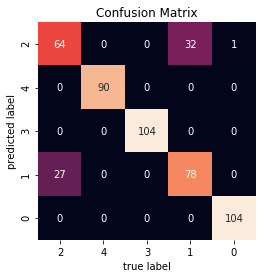

In [37]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

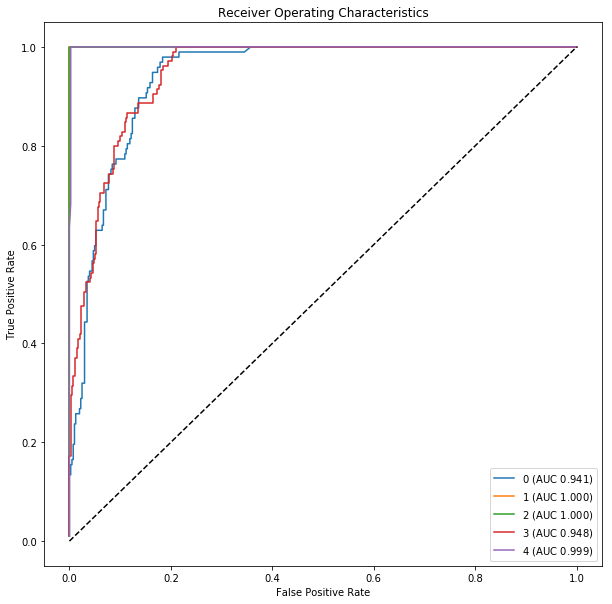

In [38]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

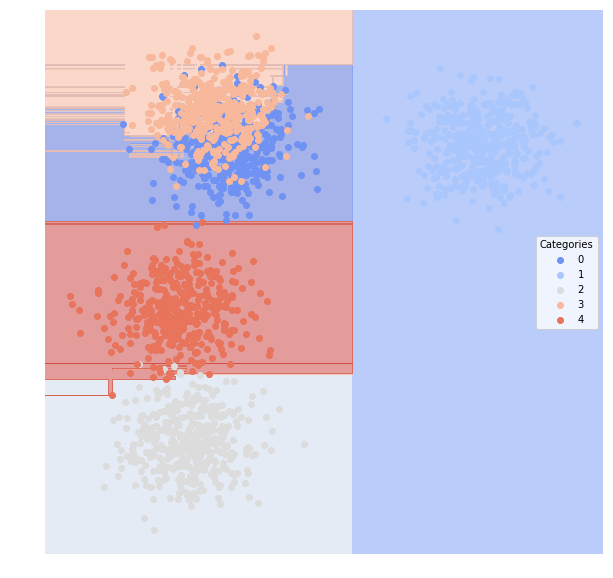

In [39]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [531]:
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


In [556]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = False) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = False) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

In [557]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [558]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
spam,0.630436,0.338339,0.105263,0.892857,0.265957
not spam,0.630436,0.894653,0.105263,0.894817,0.994915


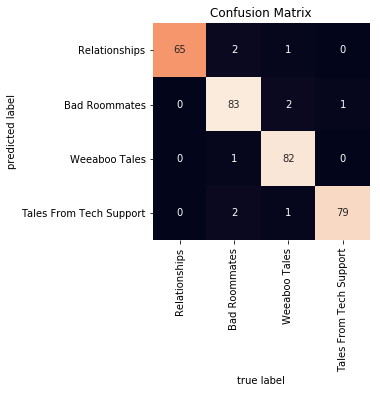

In [54]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

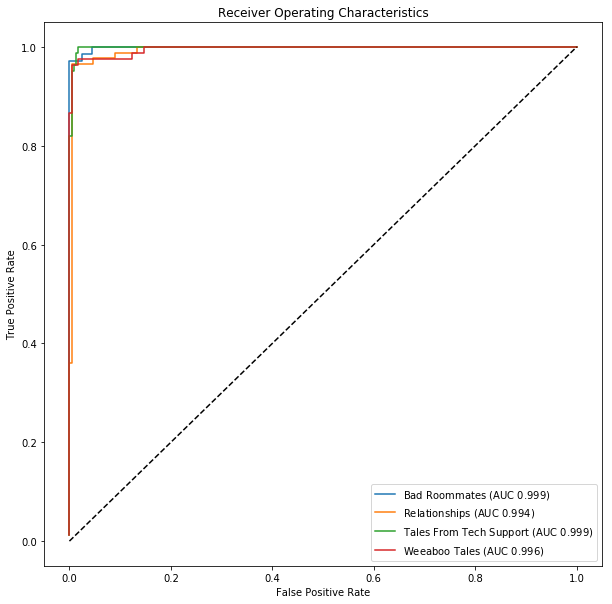

In [55]:
lucem_illud.plotMultiROC(clf, dfTest)

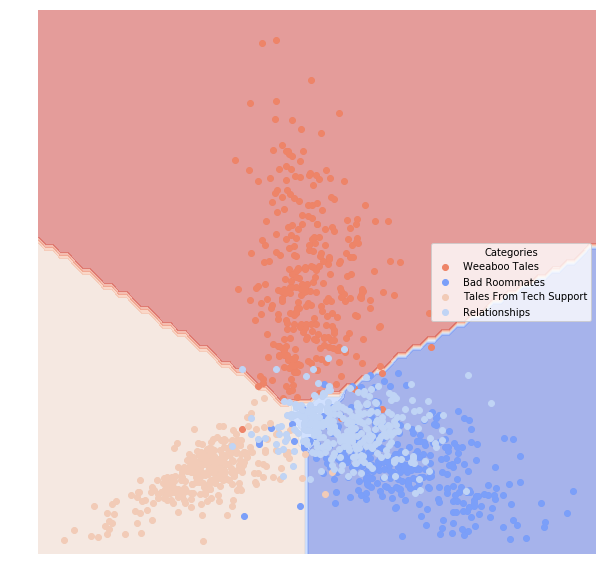

In [56]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

### Generating datasets

Generate 10 distinct datasets with different randomness

In [398]:
noise1 = .2
noise2 = .8
noise3 = .5

# noise = 1
dfTrain1, dfTest1 = lucem_illud.trainTestSplit(lucem_illud.random()) 

# noise ＝ 0.2
dfTrain2, dfTest2 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise1))
dfTrain3, dfTest3 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise1)) 
dfTrain4, dfTest4 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise1))
dfTrain5, dfTest5 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise1))

# noise = 0.8
dfTrain6, dfTest6 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise2))
dfTrain7, dfTest7 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise2)) 
dfTrain8, dfTest8 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise2))
dfTrain9, dfTest9 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise2))

# noise = 0.5
dfTrain10, dfTest10 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise3)) 

Visualize the datasets

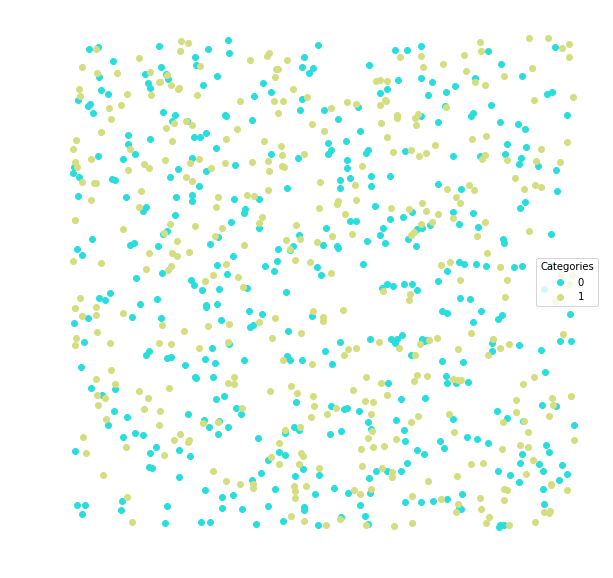

In [69]:
lucem_illud.plotter(dfTrain1)
#lucem_illud.plotter(dfTrain2)
#lucem_illud.plotter(dfTrain3)
#lucem_illud.plotter(dfTrain4)
#lucem_illud.plotter(dfTrain5)
#lucem_illud.plotter(dfTrain6)
#lucem_illud.plotter(dfTrain7)
#lucem_illud.plotter(dfTrain8)
#lucem_illud.plotter(dfTrain9)
#lucem_illud.plotter(dfTrain10)

### Classifying Datasets using MLA

In [423]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

Classify our datasets seperately by fitting the models into our datasets

In [424]:
#clf.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
#clf.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
#clf.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
#clf.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
#clf.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
#clf.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
#clf.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
#clf.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
#clf.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Evaluating Classfiers

We can evaluate each classifier's performance with various measurement by using the testing set.

Firstly, we can look at the value of AUC, average_precision, Error_rate, precision and recall.

In [425]:
#lucem_illud.evaluateClassifier(clf, dfTest1)
#lucem_illud.evaluateClassifier(clf, dfTest2)
#lucem_illud.evaluateClassifier(clf, dfTest3)
#lucem_illud.evaluateClassifier(clf, dfTest4)
#lucem_illud.evaluateClassifier(clf, dfTest5)
#lucem_illud.evaluateClassifier(clf, dfTest6)
#lucem_illud.evaluateClassifier(clf, dfTest7)
#lucem_illud.evaluateClassifier(clf, dfTest8)
#lucem_illud.evaluateClassifier(clf, dfTest9)
lucem_illud.evaluateClassifier(clf, dfTest10)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.751515,0.445127,0.184,0.573770,0.636364
1,0.582486,0.238741,0.220,0.378788,0.265957
2,0.730191,0.396558,0.166,0.557895,0.563830
3,1.000000,1.000000,0.000,1.000000,1.000000
4,0.936622,0.759582,0.058,0.803571,0.927835


Draw heatmap of confusion matrix to see which classes do better

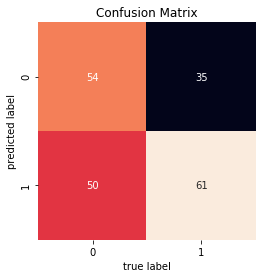

In [133]:
#lucem_illud.plotConfusionMatrix(clf, dfTest1)
#lucem_illud.plotConfusionMatrix(clf, dfTest2)
#lucem_illud.plotConfusionMatrix(clf, dfTest3)
lucem_illud.plotConfusionMatrix(clf, dfTest4)
#lucem_illud.plotConfusionMatrix(clf, dfTest5)
#lucem_illud.plotConfusionMatrix(clf, dfTest6)
#lucem_illud.plotConfusionMatrix(clf, dfTest7)
#lucem_illud.plotConfusionMatrix(clf, dfTest8)
#lucem_illud.plotConfusionMatrix(clf, dfTest9)
#lucem_illud.plotConfusionMatrix(clf, dfTest10)

Look into ROC

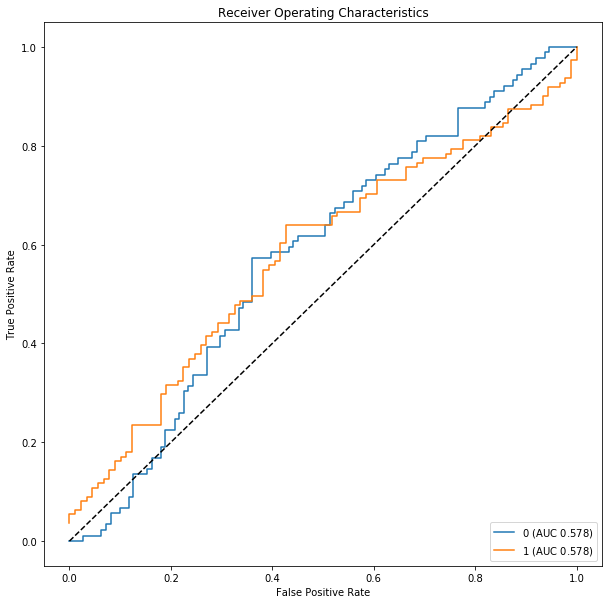

In [134]:
lucem_illud.plotMultiROC(clf, dfTest1)
#lucem_illud.plotMultiROC(clf, dfTest2)
#lucem_illud.plotMultiROC(clf, dfTest3)
#lucem_illud.plotMultiROC(clf, dfTest4)
#lucem_illud.plotMultiROC(clf, dfTest5)
#lucem_illud.plotMultiROC(clf, dfTest6)
#lucem_illud.plotMultiROC(clf, dfTest7)
#lucem_illud.plotMultiROC(clf, dfTest8)
#lucem_illud.plotMultiROC(clf, dfTest9)
#lucem_illud.plotMultiROC(clf, dfTest10)

Look at the regions the classifer identifies as one class or the other

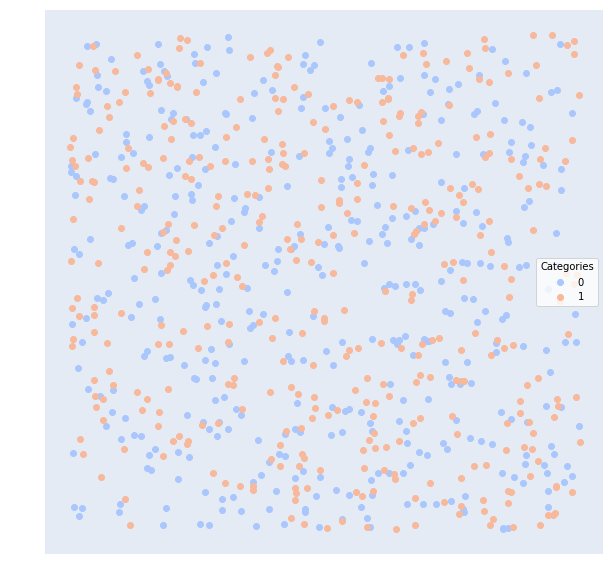

In [124]:
lucem_illud.plotregions(clf, dfTrain1)
#lucem_illud.plotregions(clf, dfTrain2)
#lucem_illud.plotregions(clf, dfTrain3)
#lucem_illud.plotregions(clf, dfTrain4)
#lucem_illud.plotregions(clf, dfTrain5)
#lucem_illud.plotregions(clf, dfTrain6)
#lucem_illud.plotregions(clf, dfTrain7)
#lucem_illud.plotregions(clf, dfTrain8)
#lucem_illud.plotregions(clf, dfTrain9)
#lucem_illud.plotregions(clf, dfTrain10)

**According to the value of AUC, which represents the performance of a model, as well as the accuracy calculated based on the confusion matrix, we can tell which classfier works best at which data:**

1) All the classifiers work very well at data 2 (auc = 0.92-0.96) and data 5 (auc = 0.98-1).

2) For data 1, data 6 and data 7, all the classifiers are not working very well, with an auc value around 0.4-0.6. The best classifiers for these three datasets are K-Neighborhood, linear SVC and poly SVC, respectively.

3) For data 3, neutral network and gradient work better than other methods, which an auc value higher than 0.9.

4) For data 5, 9 and 10, classifiers's performances are consistent. While classsification of data 5 has high accuracy, classifiers performed more unstable within data 9 and data 10, since the accuracy of each classifications vary from 0,5-1.

**From the results above, we can see some patterns about the classfiers' performances and explain why they performances vary on different data, based on our knowledge about the structures of our artificial datasets - classifiers are more likely to perform well on dataset with multiple categories and with a high randomdess.**


### Empirical Data

**After fitting all the methods into the empirical datasets (I will not repeat the codes in this part), we can conclude that the performance of these methods on different empirical data:**

1) **Naive Bayes** works best on the 2 senators data and email data, with an AUC value equals to 0.85 and 0.81, respectively.

2) **Linear SVC** works best on the Reddit (auc = 0.96-0.98) and 5 senators data (auc = 0.97-0.99), while also performed well on the news data and 2 senator data. 

3) **K-Nearest Neighbor** works best on Reddit data (acu = 91-93) and the performance is remarkable better than on other data. 

4) **Logistic Regression** works best on 2 Senators data, with an AUC equals to 0.98, and also performs well on Reddit and 5 Senators. 

5) **Decision Tree** and **Random Forest** perform very well at the two senator datasets (auc > 0.95, even equal to 1). But the accuracy on other empirical data are not higher than 90%.

6) **Neural Networks** works well on all the empirical data except for the email one (AUC for email is only 0.78. But for other data are higher than 0.9). And works best on Reddit and 5 Senators.

7) **Gradient** works best on the 2 senators data, with an AUC of 0.996. Also performs well on Reddit data (the acu of the most percisive category is 0.98)

**Mostly consistent with our conclusion of artifical datasets, we can see than most of the classifiers work well on datasets with multiple categories. But it is worth mention that naive bayes performs better on datasets with binary categoires (like the 2 senator data and email data).**

### Stretch: AdaBoost

I will use a new `SKLearn` method to classify the artifitial and real datasets - `AdaBoost` classfier. 

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

The algorithm we used here is `AdaBoost-SAMME.R`.

#### Artificial Datasets

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

In [560]:
#Control the number of weak learner as 50.
clf = sklearn.ensemble.AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, random_state=None)

In [587]:
#clf.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
#clf.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
#clf.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
#clf.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
#clf.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])
#clf.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])
#clf.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])
#clf.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])
#clf.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])
clf.fit(np.stack(dfTrain10['vect'], axis=0), dfTrain10['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [588]:
lucem_illud.evaluateClassifier(clf, dfTest10)

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.757692,0.488000,0.154,0.666667,0.600000
1,0.500000,0.188000,0.188,0.000000,0.000000
2,0.824049,0.424676,0.226,0.449735,0.904255
3,1.000000,1.000000,0.000,1.000000,1.000000
4,0.917244,0.734593,0.064,0.803738,0.886598


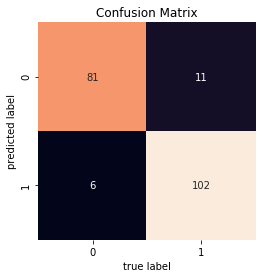

In [101]:
lucem_illud.plotConfusionMatrix(clf, dfTest2)

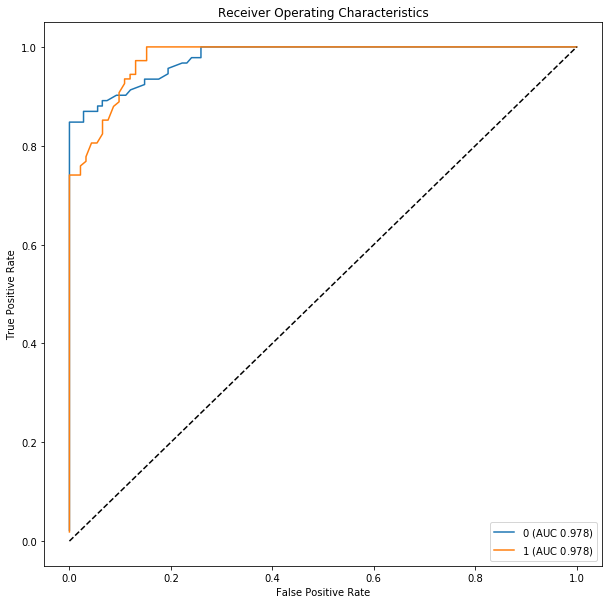

In [102]:
lucem_illud.plotMultiROC(clf, dfTest2)

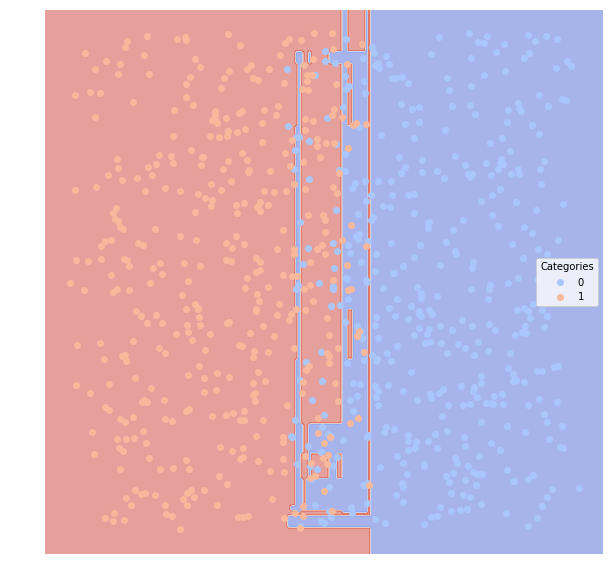

In [103]:
lucem_illud.plotregions(clf, dfTrain2)

#### Real Datasets

In [601]:
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


In [602]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [603]:
lucem_illud.evaluateClassifier(clf, dfTrain)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
spam,0.771747,0.544301,0.081782,0.850909,0.561151
not spam,0.771747,0.924354,0.081782,0.925731,0.982343


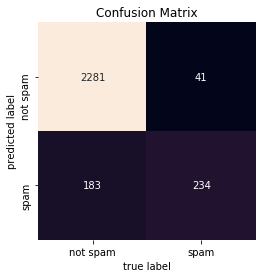

In [604]:
lucem_illud.plotConfusionMatrix(clf, dfTrain)

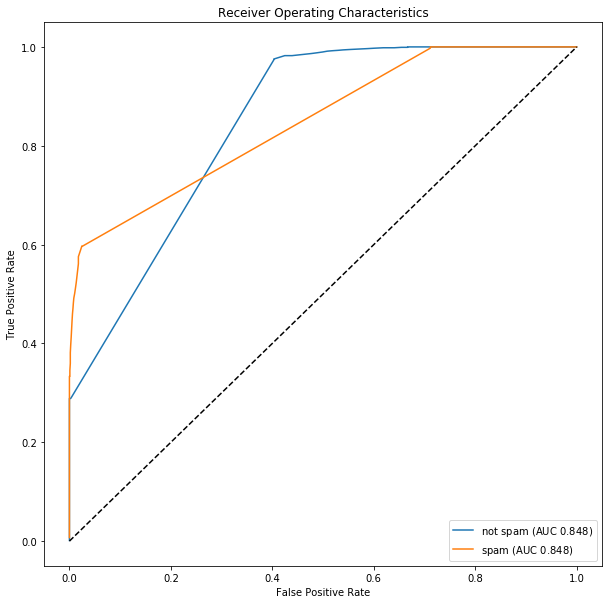

In [605]:
lucem_illud.plotMultiROC(clf, dfTrain)

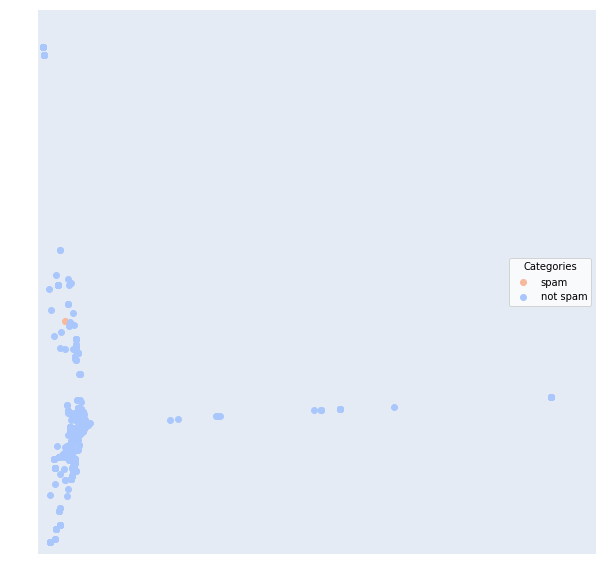

In [606]:
lucem_illud.plotregions(clf, dfTrain)

**As an ensemble method, the performance of `AdaBoost` classifier on our datasets is similar to the other ensemble method like the Gradient. **

**For empirical datasets, it works pretty good on all the datasets except for the email one. For artificial datasets, it works best on data 5 and data 9 (AUC > 0.9), which are all dataset with multiple categories. **

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [607]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

In [689]:
ObamaClintonReleases[:5]

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama,True,"[Obama, Calls, on, IRS, to, Protect, Taxpayers...","[obama, call, ir, protect, taxpay, privaci, u,..."
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama,True,"[Statement, from, Senator, Barack, Obama, on, ...","[statement, senat, barack, obama, dodd, shelbi..."
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama,True,"[Obama, Says, Bill, Will, Help, Cut, Off, Supp...","[obama, say, bill, help, cut, suppli, danger, ..."
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama,True,"[Obama, Durbin, Say, Illinois, Will, Receive, ...","[obama, durbin, say, illinoi, receiv, percent,..."
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama,True,"[Obama, Introduces, Bill, to, Help, Tap, Power...","[obama, introduc, bill, help, tap, power, geno..."


Let's turn the 'targetSenator' column into a binary category variable.

In [608]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [609]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Let's split the data into training data and testing data.

In [613]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [614]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [615]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [616]:
TFVects.shape

(1368, 11204)

We can save this in the dataframe to make things easier

In [617]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [618]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [619]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

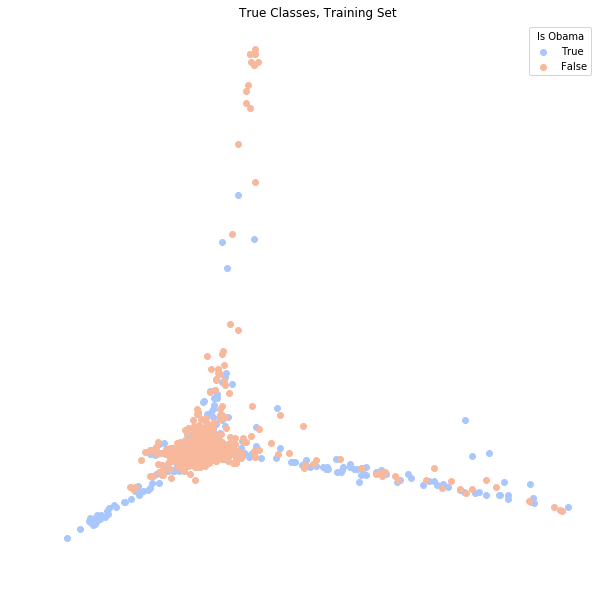

In [620]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

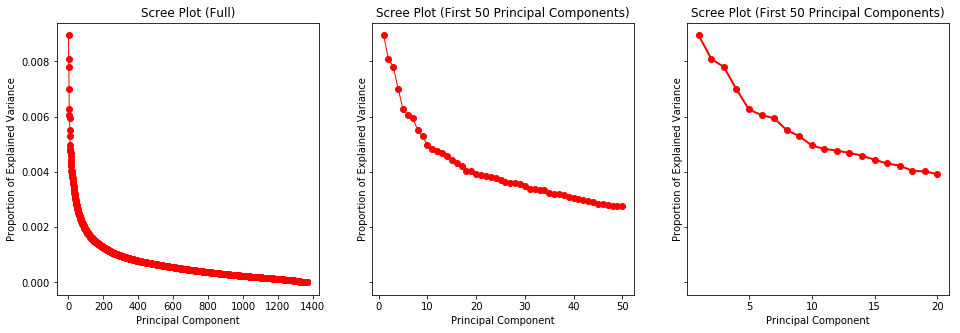

In [621]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [622]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [623]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [624]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6652046783625731

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [625]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6920821114369502

Slightly poorer. How about using more dimensions (40)?

In [626]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7426900584795322
Testing:
0.7800586510263929


Or still more (100)?

In [627]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8245614035087719
Testing:
0.8240469208211144


Or even more (200)!

In [628]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8647660818713451
Testing:
0.8533724340175953


This is becoming ridiculous (400)!

In [629]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9159356725146199
Testing:
0.844574780058651


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [630]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.810672514619883


Train the model using training data, and then test it on the testing data.

In [631]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.7859237536656891


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [632]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [633]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9619883040935673
Testing:
0.8797653958944281


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [634]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [635]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.8582089552238806

Recall:

In [636]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.8394160583941606

F1-measure:

In [637]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.8487084870848708

Let's take a look at how well our posterior distribution looks relative to the truth.

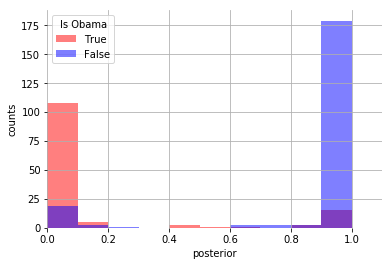

In [638]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [639]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Clinton,Clinton_log_prob,Obama,Obama_log_prob
0,amy,-1.825243,signature,-2.201005
1,dick,-1.836054,island,-2.271623
2,brundage,-1.891934,fy,-2.334537
3,chicago,-1.951123,welcomed,-2.334537
4,temporary,-2.168188,urging,-2.360854
5,political,-2.230708,construction,-2.401676
6,va,-2.230708,ground,-2.401676
7,location,-2.246968,read,-2.401676
8,reform,-2.263498,honor,-2.415662
9,cases,-2.280305,urban,-2.415662


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [640]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [641]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [642]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: nltk.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [643]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [644]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [645]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [646]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [647]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.893789901334881


In [648]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1914,comp.graphics,comp.graphics
236,talk.religion.misc,talk.religion.misc
396,soc.religion.christian,soc.religion.christian
949,soc.religion.christian,soc.religion.christian
823,soc.religion.christian,soc.religion.christian
189,talk.religion.misc,talk.religion.misc
794,soc.religion.christian,soc.religion.christian
1229,sci.space,sci.space
2002,comp.graphics,comp.graphics
1137,sci.space,sci.space


Looks pretty good, lets examine the testing dataset:

In [649]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7767441860465116


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

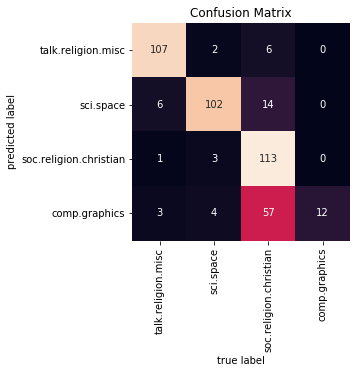

In [650]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [651]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.900146880465397
0.7767441860465116
0.8098823192149878


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [652]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
sci.space,0.903422,0.814788,0.067442,0.918919,0.836066
talk.religion.misc,0.578947,0.306732,0.148837,1.000000,0.157895
comp.graphics,0.949344,0.869515,0.041860,0.914530,0.930435
soc.religion.christian,0.859903,0.583706,0.188372,0.594737,0.965812


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

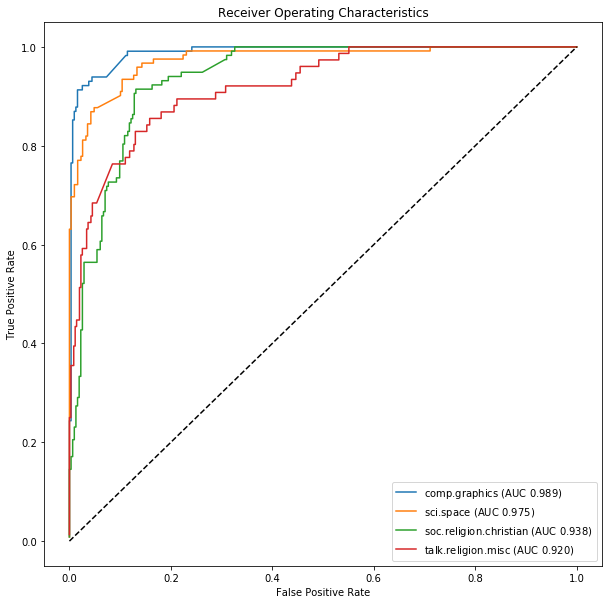

In [653]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

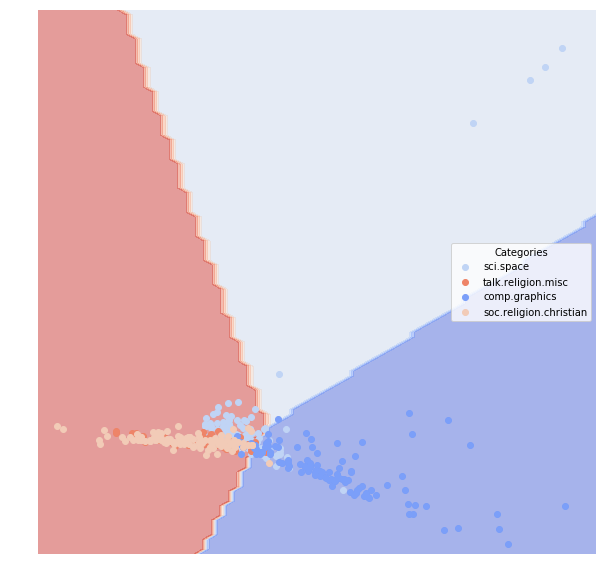

In [654]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

We can also give the model a new string, not present in our data, and use the *predict* method to see if it can assign it to a category. Using our model to extend its classifications to new, uncoded data might be the primary purpose of a social science application. The words do have to be in the vocabulary, so don't be too creative :-)

In [655]:
def predict_category(s, model, tfidf): #We just define a simple function here
    a = np.zeros((1, len(tfidf.vocabulary_)))
    for w in nltk.word_tokenize(s):
        try:
            a[:,tfidf.vocabulary_[lucem_illud.stemmer_basic.stem(w.lower())]] = 1
        except KeyError:
            print("Warning: '{}' not in vocabulary".format(w))
    return model.predict(a)[0]

In [656]:
predict_category('rockets are cool', MultinomialNB_ng, TFVectorizer_ng)

'sci.space'

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


### Trump 100 Days Tweets Data

In this homework, I will continue using the data of Trump's 100 days tweets. Here I will the dataset that contains 500 samples of tweets, which already coded into three categories (Positive, Negative and Neutral) through MTruk. 

In [819]:
trump = pandas.read_csv('../data/trumpCoded.csv', index_col=0)

In [820]:
trump[:10]

,text,category
0,RT @immigrant4trump: Antifa Thug pepper-sprays...,Neutral
1,"RT @mmfa: NRATV blames ""Obama loyalists"" for c...",Negative
2,DrDavidDuke: Did John McCain wiretap President...,Neutral
3,RT @CBSNews: Pres. Trump says Mike Pence will ...,Neutral
4,RT @thehill: Connecticut governor to cops: Don...,Neutral
5,RT @TrueFactsStated: CNN has this wrong. Putin...,Negative
6,RT @Thomas1774Paine: #FBI Russia Probe Failed ...,Negative
7,"RT @Khanoisseur: 2. Even if he leaves Trump, M...",Neutral
8,RT @JordanUhl: Don't worry everyone. After Tru...,Negative
9,RT @TeaPainUSA: Wouldn't it be a simpler inves...,Neutral


In [821]:
trump['tokenized_text'] = trump['text'].apply(lambda x: nltk.word_tokenize(x))
trump['normalized_text'] = trump['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Split the data into training data and test data

In [822]:
holdBackFraction = .2
trump_train, trump_test = lucem_illud.trainTestSplit(trump, holdBackFraction=holdBackFraction)

In [823]:
print(len(trump_train))
print(len(trump_test))

401
100


### Logistic Regression

Turn the training dataset into a tf-idf matrix 

In [824]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(trump_train['text'])

In [825]:
TFVects.shape

(401, 586)

In [826]:
#Save in the dataframe
trump_train['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

I will firstly do a dimension reduction. To this end, we can use PCA.

In [827]:
pca = sklearn.decomposition.PCA()
trump_reduced = pca.fit_transform(np.stack(trump_train['vect'], axis=0))

In [828]:
#Save the PCA space vectors in the dataframe
trump_train['pca'] = [r for r in trump_reduced]

Perform a screeplot to see how many Principal Components we need

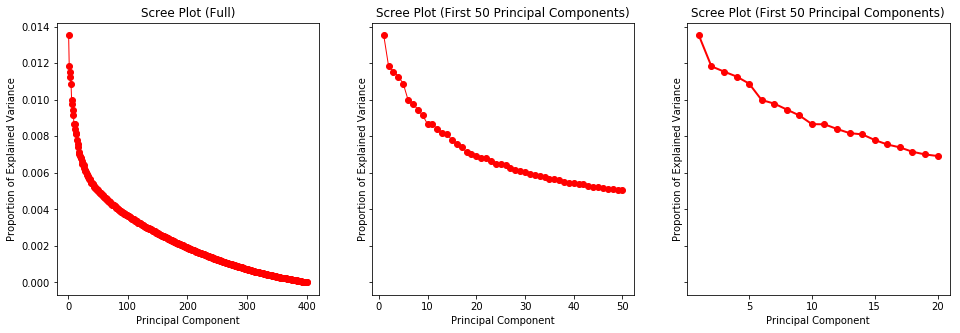

In [829]:
n = len(trump_train)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Based on the screenplot, I will choose the first 10 pricipal components as covariates

In [830]:
trump_train['pca_reduced_10'] = trump_train['pca'].apply(lambda x: x[:10])

Now we can fit a logistic regression to the data

In [831]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(trump_train['pca_reduced_10'], axis=0), trump_train['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We can calculate the mean accuracy of the logistic regression to our data.

In [832]:
logistic.score(np.stack(trump_train['pca_reduced_10'], axis=0), trump_train['category'])

0.49875311720698257

The mean accuracy is only 49%, which means the logistic regression doesn't fit our data well.

Now let's see how it perform on the testing dataset.

In [833]:
#Create vectors
TFVects_test = TFVectorizer.transform(trump_test['text'])
trump_test['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
trump_reduced_test = pca.transform(np.stack(trump_test['vect'], axis=0))
trump_test['pca'] = [r for r in trump_reduced_test]
trump_test['pca_reduced_10'] = trump_test['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(trump_test['pca_reduced_10'], axis=0), trump_test['category'])

0.47

The mean accuracy is still low. We can try with more dimensions (50).

In [834]:
trump_train['pca_reduced_50'] = trump_train['pca'].apply(lambda x: x[:50])
trump_test['pca_reduced_50'] = trump_test['pca'].apply(lambda x: x[:50])

logistic.fit(np.stack(trump_train['pca_reduced_50'], axis=0), trump_train['category'])

print("Training:")
print(logistic.score(np.stack(trump_train['pca_reduced_50'], axis=0), trump_train['category']))
print("Testing:")
print(logistic.score(np.stack(trump_test['pca_reduced_50'], axis=0), trump_test['category']))

Training:
0.6084788029925187
Testing:
0.49


And more (100)

In [835]:
trump_train['pca_reduced_100'] = trump_train['pca'].apply(lambda x: x[:100])
trump_test['pca_reduced_100'] = trump_test['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(trump_train['pca_reduced_100'], axis=0), trump_train['category'])

print("Training:")
print(logistic.score(np.stack(trump_train['pca_reduced_100'], axis=0), trump_train['category']))
print("Testing:")
print(logistic.score(np.stack(trump_test['pca_reduced_100'], axis=0), trump_test['category']))

Training:
0.683291770573566
Testing:
0.5


After increasing the number of covariates, the best prediction accuracy of logistic regression is about 68%. 

We can also try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function. Similarly, I will train the model using training data, and test it using testing data.

In [836]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(trump_train['vect'], axis=0), trump_train['category'])
print(logistic_l1.score(np.stack(trump_train['vect'], axis=0), trump_train['category']))

0.543640897755611


In [837]:
print(logistic_l1.score(np.stack(trump_test['vect'], axis=0), trump_test['category']))

0.47


THe accuracy is still not very well.

Confusion matrix:

In [913]:
trump_test['vect_full'] = trump_test['vect']
trump_test['vect'] = trump_test['pca_reduced_100']

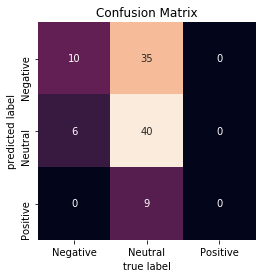

In [914]:
lucem_illud.plotConfusionMatrix(logistic, trump_test)

Precision, recall and AUC:

In [915]:
lucem_illud.evaluateClassifier(logistic, trump_test)

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Negative,0.556566,0.488889,0.41,0.62500,0.222222
Neutral,0.527375,0.474079,0.50,0.47619,0.869565
Positive,0.500000,0.090000,0.09,0.00000,0.000000


Plot the ROC

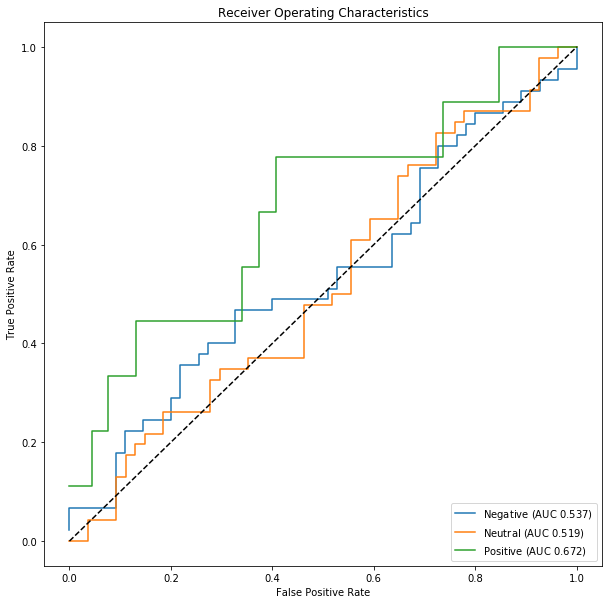

In [917]:
lucem_illud.plotMultiROC(logistic, trump_test)

**Based on the confusion matrix, AUC, precision and recall value, the performance of logistic regression is not very good. The average accuracy, according to the confusion matrix, is about 50%, and the precesion for neutral category is even lower than 0.5. Also, a major problem is that sample size of positive category is small, so there are barely no positive sample in the testing size.**

### Naive Bayes

In [839]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(trump_train['vect'], axis=0), trump_train['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [840]:
print("Training:")
print(naiveBayes.score(np.stack(trump_train['vect'], axis=0), trump_train['category']))
print("Testing:")
print(naiveBayes.score(np.stack(trump_test['vect'], axis=0), trump_test['category']))

Training:
0.8104738154613467
Testing:
0.46


In [845]:
#Save the prediction
trump_train['nb_predict'] = naiveBayes.predict(np.stack(trump_train['vect'], axis=0))
trump_train['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(trump_train['vect'], axis=0))[:,0] #other is prop false
trump_test['nb_predict'] = naiveBayes.predict(np.stack(trump_test['vect'], axis=0))
trump_test['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(trump_test['vect'], axis=0))[:,0] #other is prop false

In [846]:
trump_train[['category', 'nb_predict']][:10]

,category,nb_predict
331,Negative,Negative
90,Negative,Negative
479,Negative,Negative
1,Negative,Negative
87,Negative,Negative
119,Neutral,Neutral
295,Neutral,Neutral
425,Neutral,Neutral
260,Neutral,Neutral
406,Neutral,Neutral


Confusion matrix:

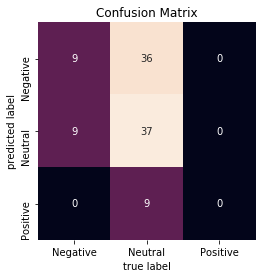

In [847]:
lucem_illud.plotConfusionMatrix(naiveBayes, trump_test)

According to the confusion matrix, we can calculate that the average accuracy is 47%. For each category, the precision of neutral is 45% and the the precision of negative is 50%. There is no positive label in the testing dataset. It seems like naive bayes cannot classify negative and neutral very well

Precision:

In [848]:
sklearn.metrics.precision_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted')

0.6955652173913043

Recall:

In [849]:
sklearn.metrics.recall_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted')

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.46

F-measures:

In [850]:
sklearn.metrics.f1_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted')

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.5254910714285714

Perform ROC visualization

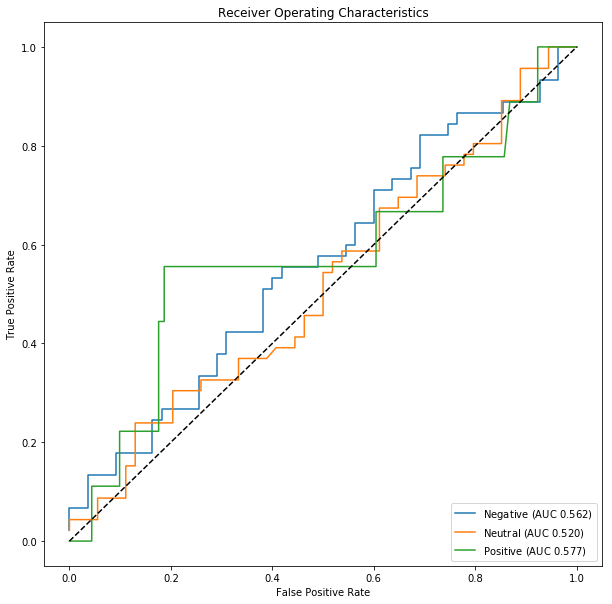

In [851]:
lucem_illud.plotMultiROC(naiveBayes, trump_test)

**Based on all the relevant matrixs we have calculated and performed above, the overall performance of naive bayes classifier is not satisfied. The AUC value for each categories are approximately from 52%-57%. Average precision is 69%, recall is 46% while F-measure is 52%, which means this classifier can only correctly predict approximately half of the sample.**

### Multiple Naive Bayes

In [806]:
MultinomialNB_trump = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_trump.fit(np.stack(trump_train['vect'], axis = 0), trump_train['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [807]:
#Save prediction to the dataframe
trump_train['nb_predict'] = MultinomialNB_trump.predict(np.stack(trump_train['vect'], axis=0))
print("Training score:")
print(MultinomialNB_trump.score(np.stack(trump_train['vect'], axis=0), trump_train['category']))

Training score:
0.8453865336658354


In [808]:
trump_train[['category', 'nb_predict']][:10]

,category,nb_predict
15,Neutral,Neutral
106,Neutral,Neutral
271,Neutral,Neutral
248,Negative,Negative
254,Negative,Negative
494,Negative,Negative
121,Negative,Negative
18,Neutral,Neutral
129,Positive,Neutral
184,Neutral,Neutral


The mean accuracy is 84%, way much better than logistic regression. Let's also examine it in the testing data

In [809]:
print("Testing score:")
print(MultinomialNB_trump.score(np.stack(trump_test['vect'], axis=0), trump_test['category']))

Testing score:
0.41


#### Evaluating 

Confusion Matrix

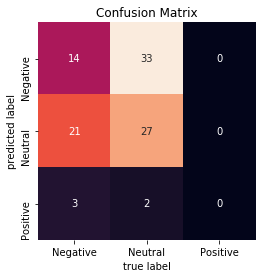

In [810]:
lucem_illud.plotConfusionMatrix(MultinomialNB_trump, trump_test)

In [812]:
print(sklearn.metrics.precision_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted')) #precision

0.575531914893617


Recall:

In [813]:
print(sklearn.metrics.recall_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted')) #recall

0.45


/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F-measures:

In [814]:
print(sklearn.metrics.f1_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted')) #F-1 measure

0.49013333333333337


/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Perform ROC visualization:

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


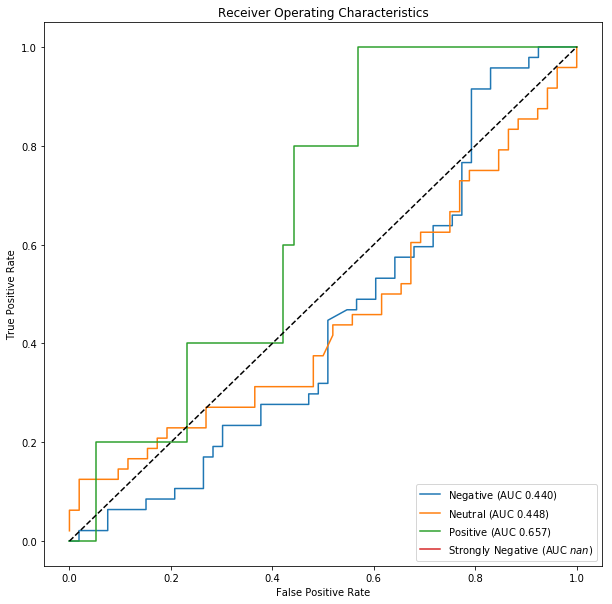

In [815]:
lucem_illud.plotMultiROC(MultinomialNB_trump, trump_test)

### Extrapolating to Uncoded Data

In [852]:
def predict_category(s, model, tfidf): #We just define a simple function here
    a = np.zeros((1, len(tfidf.vocabulary_)))
    for w in nltk.word_tokenize(s):
        try:
            a[:,tfidf.vocabulary_[lucem_illud.stemmer_basic.stem(w.lower())]] = 1
        except KeyError:
            print("Warning: '{}' not in vocabulary".format(w))
    return model.predict(a)[0]

In [854]:
predict_category('great america', naiveBayes, TFVectorizer)

'Neutral'

In [ ]:
predict_category('great america', logistic, TFVectorizer)

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

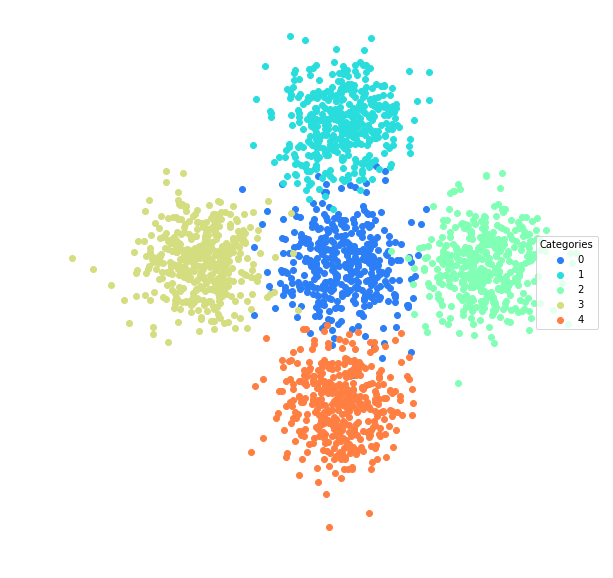

In [761]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [762]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

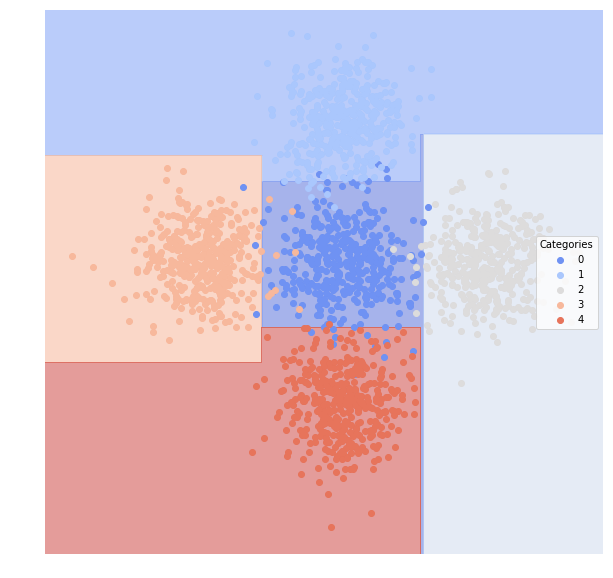

In [763]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [764]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.964184,0.880237,0.028,0.915094,0.950980
1,0.994681,0.991362,0.002,1.000000,0.989362
2,0.969671,0.938282,0.016,0.980769,0.944444
3,0.988239,0.972533,0.006,0.989362,0.978947
4,0.991290,0.963261,0.008,0.970874,0.990099


Lets look at accuracy:

In [765]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.97

What happens if we trim the tree?

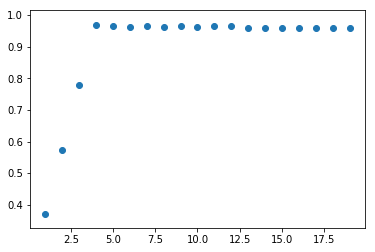

In [766]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [767]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [768]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

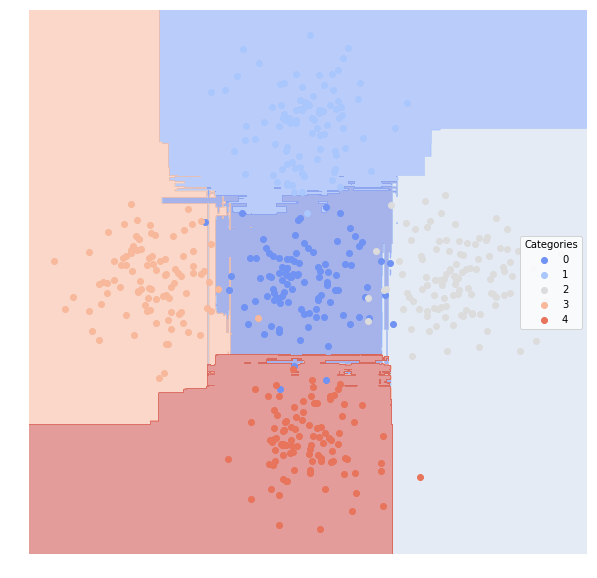

In [769]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [770]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.954380,0.864773,0.032,0.913462,0.931373
1,0.993449,0.980837,0.004,0.989362,0.989362
2,0.973025,0.936712,0.016,0.971698,0.953704
3,0.982976,0.964008,0.008,0.989247,0.968421
4,0.991290,0.963261,0.008,0.970874,0.990099


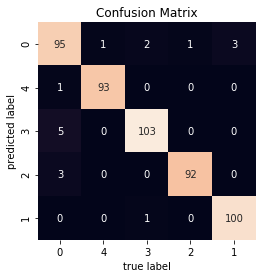

In [771]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

### Decision Tree

Continue using the coded trump data, now I will use the decision tree model to classify the data.

Firstly, let's fit the decision tree model into training dataset

In [855]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(trump_train['vect'], axis =0), trump_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Visualize the classifications.

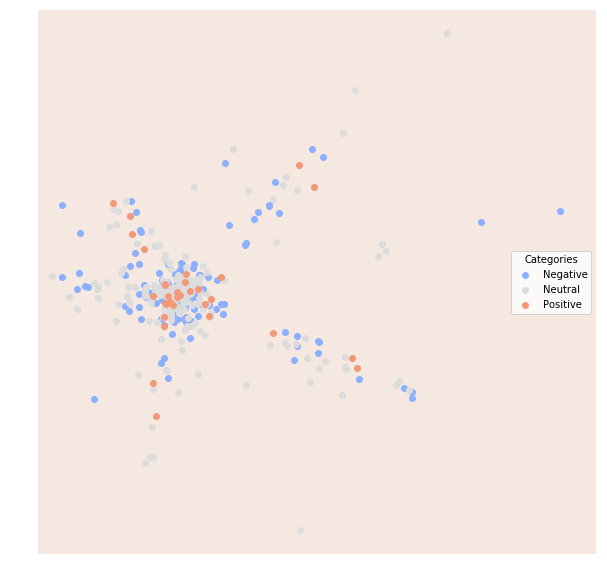

In [856]:
lucem_illud.plotregions(clf_tree, trump_train)

**The religions are highly overlapping with each other, which means that the classification of negative, neutral and positive is not very clear, using decesion tree.**

We can also perform the decision tree classification using testing dataset and visualize it.

In [876]:
clf_tree.fit(np.stack(trump_test['vect'], axis =0), trump_test['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

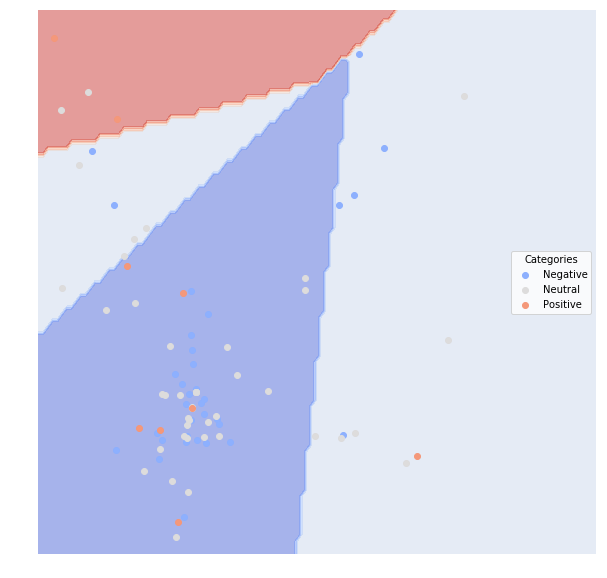

In [877]:
lucem_illud.plotregions(clf_tree, trump_test)

**Here in the testing dataset, the negative and neutral categories are still overlapping.**

Evaluate this classifier by calculating relevant matrixs including AUC, precision, recall and f-measures

In [857]:
lucem_illud.evaluateClassifier(clf_tree, trump_test)

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Negative,0.50202,0.451111,0.45,0.500000,0.022222
Neutral,0.49839,0.459201,0.54,0.459184,0.978261
Positive,0.50000,0.090000,0.09,0.000000,0.000000


Calculate the accuracy

In [858]:
sklearn.metrics.accuracy_score(trump_test['category'],clf_tree.predict(np.stack(trump_test['vect'], axis = 0)))

0.46

Calculate the F-measures

In [886]:
trump_test['nb_predict'] = clf_tree.predict(np.stack(trump_test['vect'], axis=0))
print(sklearn.metrics.f1_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted')) #F-1 measure

0.662848711943794


**Based on the relevant matrixs we calculated above, the performance of decision tree is not very well. The average accuracy of classification is 46% and the F-measures is 66%. The AUC value for neutral is 49%, and error_rate is more than 50%. This classifier works a little better (but still not good) on the category of negative, since the AUC is 50% and error_rate is 45%.**

Let's try to trim the tree:

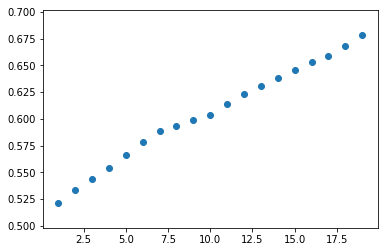

In [860]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(trump_train['vect'], axis =0), trump_train['category'])
    score = sklearn.metrics.accuracy_score(trump_train['category'], tree2.predict(np.stack(trump_train['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

### Random Forest

We can also Bbild a random forest classifier by bagging decision trees.

In [861]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [862]:
bag.fit(np.stack(trump_train['vect'], axis =0), trump_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

Visualize the classifications

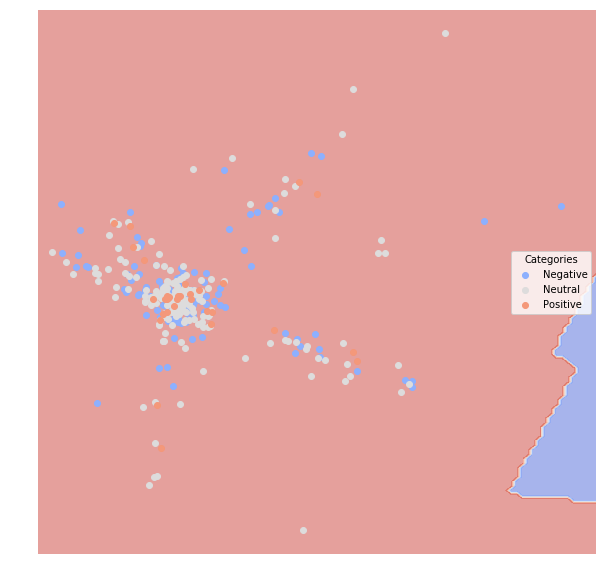

In [878]:
lucem_illud.plotregions(bag, trump_train)

Also try random forest in testing dataset

In [879]:
bag.fit(np.stack(trump_test['vect'], axis =0), trump_test['category']) 

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

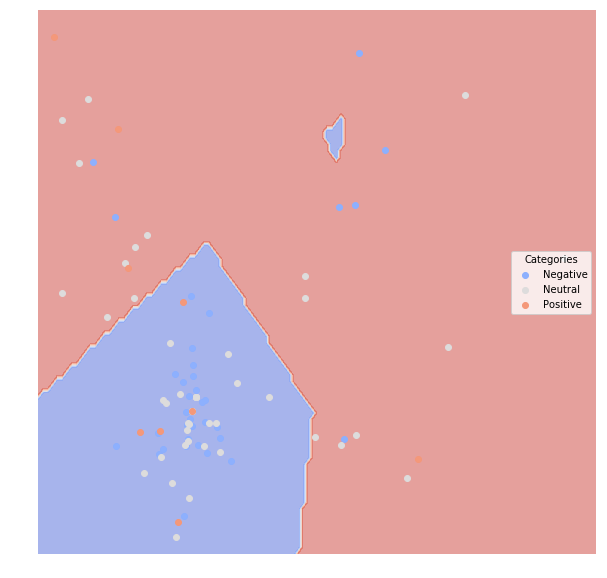

In [880]:
lucem_illud.plotregions(bag, trump_test)

**Same as the decision tree model, the random forest is not performing well on claasifying our data. The categories are overlapping with each other, especially between negative and neutral.**

Calculate AUC, precision and recall

In [864]:
lucem_illud.evaluateClassifier(bag, trump_test)

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Negative,0.510101,0.455556,0.45,0.500000,0.111111
Neutral,0.491948,0.456039,0.54,0.455556,0.891304
Positive,0.500000,0.090000,0.09,0.000000,0.000000


Calculate the F-measures

In [887]:
trump_test['nb_predict'] = bag.predict(np.stack(trump_test['vect'], axis=0))
print(sklearn.metrics.f1_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted'))

0.9208622931442081


Build a confusion matrix

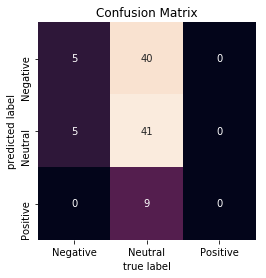

In [865]:
lucem_illud.plotConfusionMatrix(bag, trump_test)

**As we can see, although F-measures (0.92) of the random forest classifer is higher than the decision tree model, the average accuracy, based on confusion matrix, is still low (around 50%). Also, the AUC of each categories is from 49-51%, which are not very satisfied performances. The major problem here is still the classification between negative and neutral tweets.**

**The way of ensemble learning works here is to build several estimator independently and then to average their predictions. We can see that in our dataset, the the combined estimator improved the performance of the classification by reducing the variances, although the improving effect is limited.**



# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [866]:
newsgroupsDF[:5]

,category,source_file,text,tokenized_text,normalized_text
0,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nParadise and salvation are not the same th...,"[Paradise, and, salvation, are, not, the, same...","[paradis, salvat, thing, salvat, better, refer..."
1,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,\nYou're admitting a lot more than that. You ...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situat, admit, acti..."
2,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\n\nJesus also recognized other holy days, lik...","[Jesus, also, recognized, other, holy, days, ,...","[jesus, also, recogn, holi, day, like, passov,..."
3,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,"[In, <, lsjc8cINNmc1, @, saltillo.cs.utexas.ed...","[turpin, russel, turpin, regard, love, less, b..."
4,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\nI'm sorry, but He does not! Ever read the F...","[I, 'm, sorry, ,, but, He, does, not, !, Ever,...","[sorri, doe, ever, read, first, command]"


Make a testing and training set:

In [867]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [868]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [869]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [870]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [871]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
sci.space,0.531046,0.299092,0.290772,0.432624,0.126556
talk.religion.misc,0.551426,0.193296,0.362159,0.219130,0.418605
comp.graphics,0.550958,0.293126,0.498549,0.304866,0.658798
soc.religion.christian,0.500000,0.275102,0.275102,0.000000,0.000000


And lets look at the testing data

In [872]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2255813953488372


Let's produce another confusion matrix:

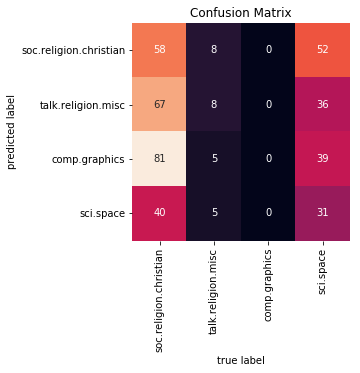

In [873]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

Initialize k-nearest neighbors classifier

In [874]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Fit the model into our training dataset

In [875]:
clf_knearest.fit(np.stack(trump_train['vect'], axis = 0), trump_train['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

Visualize the classification of data points

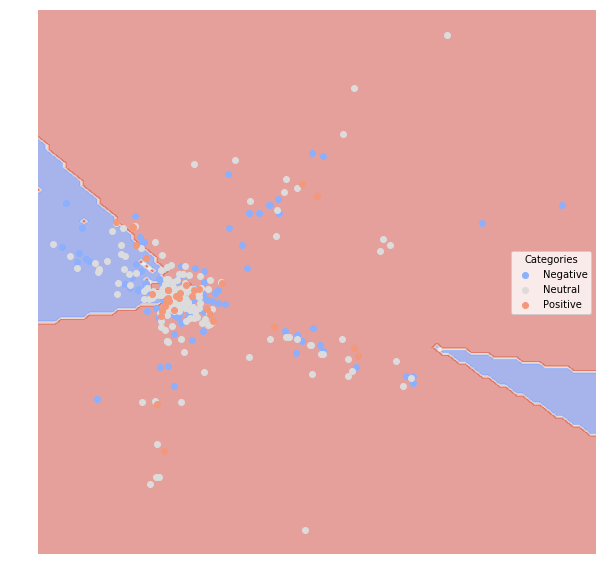

In [882]:
lucem_illud.plotregions(clf_knearest, trump_train)

Calculate AUC, precision and Recall

In [883]:
lucem_illud.evaluateClassifier(clf_knearest, trump_test)

/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Negative,0.582828,0.507980,0.39,0.636364,0.311111
Neutral,0.562802,0.493913,0.46,0.500000,0.847826
Positive,0.500000,0.090000,0.09,0.000000,0.000000


Calculate F-measures

In [888]:
trump_test['nb_predict'] = clf_knearest.predict(np.stack(trump_test['vect'], axis=0))
print(sklearn.metrics.f1_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted'))

0.5825854597977852


/Users/czd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Also fit this model into testing data

In [884]:
print("Testing score:")
print(clf_knearest.score(np.stack(trump_test['vect'], axis=0), trump_test['category']))

Testing score:
0.53


Build the confusion matrix

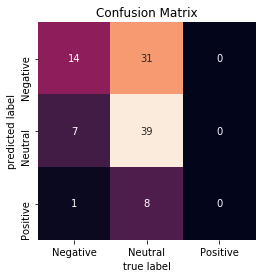

In [885]:
lucem_illud.plotConfusionMatrix(clf_knearest, trump_test)

**In all, the performance of K-nearest neighbor classification is better than symbolist methods like decision tree and random forest. The average accuracy, according to the confusion matrix is 53%, although the classifer still had difficulty in classifying negative and neutral tweets, the error rate of prediction is better than decision tree and random forest model.**

**While K-means clustering we learned from week 3 is a clustering algorithm that tries to partition a set of points into K sets (clusters) such that the points in each cluster tend to be near each other, the K-nearest neighbor is a classification algorithm that in order to determine the classification of a point, combines the classification of the K nearest points. When K-means is unsupervised, the K-NN is under supervised.**


# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [889]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

We will tf.idf the data to make our vectors:

In [890]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [891]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [892]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

...and consider the results:

In [893]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.965014,0.913008,0.021944,0.955882,0.942029
Weeaboo Tales: stories about the extreme fans of japanese culture,0.997925,0.987342,0.003135,0.987342,1.000000
Tales From Tech Support,0.997807,0.989130,0.003135,0.989130,1.000000
Relationships,0.960732,0.907032,0.028213,0.950000,0.938272


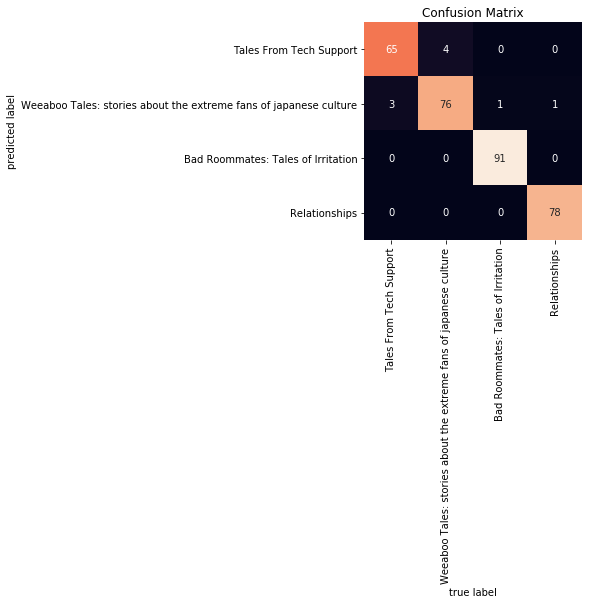

In [894]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

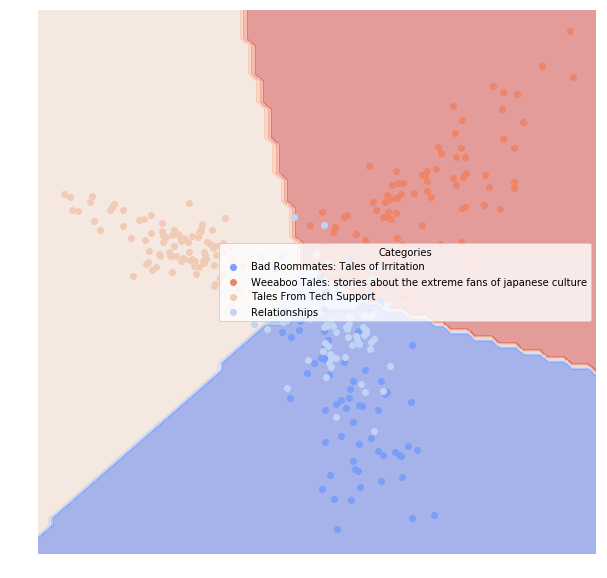

In [895]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [899]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [900]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.952522,0.903759,0.025078,0.969231,0.913043
Weeaboo Tales: stories about the extreme fans of japanese culture,0.987366,0.953295,0.012539,0.962500,0.987179
Tales From Tech Support,1.000000,1.000000,0.000000,1.000000,1.000000
Relationships,0.962704,0.894437,0.031348,0.927711,0.950617


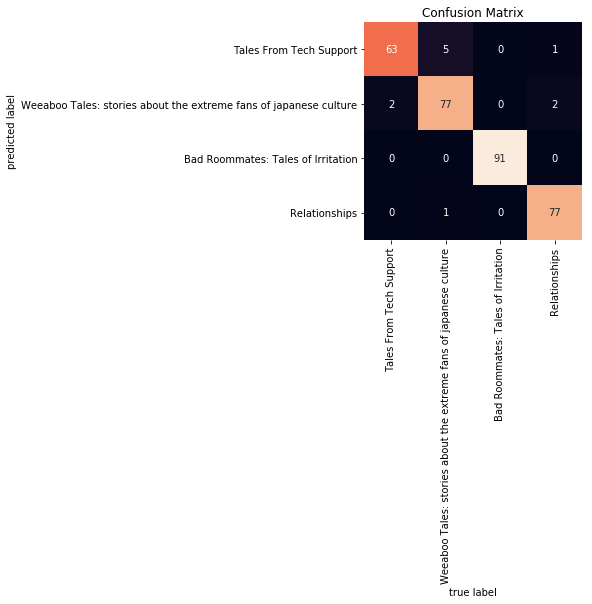

In [901]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

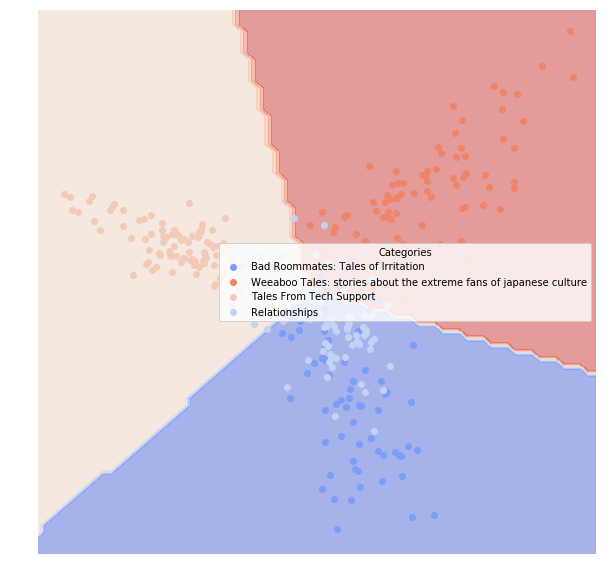

In [902]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [903]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(trump_train['vect'], axis=0), trump_train['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Visualize the classifications using data point

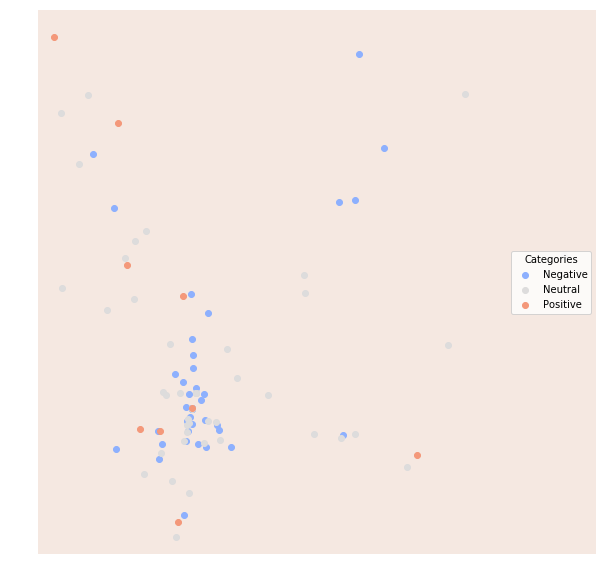

In [910]:
lucem_illud.plotregions(clf_nn, trump_test)

Evaluating the classifier using AUC, recall, precision.

In [906]:
lucem_illud.evaluateClassifier(clf_nn, trump_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Negative,0.581818,0.502258,0.40,0.580645,0.400000
Neutral,0.591787,0.512663,0.42,0.531250,0.739130
Positive,0.533578,0.102222,0.12,0.200000,0.111111


Also calculate F-measures

In [909]:
trump_test['nb_predict'] = clf_nn.predict(np.stack(trump_test['vect'], axis=0))
print(sklearn.metrics.f1_score(trump_test['nb_predict'], trump_test['category'], average = 'weighted'))

0.5496213260423787


Finally, build a confusion matrix to see the accuracy and precision

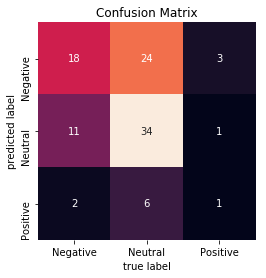

In [905]:
lucem_illud.plotConfusionMatrix(clf_nn, trump_test)

**In all, the performance of neural network is better than decision tree, random forest and k-nearset neighbor approach on our data. According to the confusion matrix, the average accuracy of classification is 71%. The AUC for each categories are from 53%-59%. **



### Conclusion

In this homework, I have performed various classification methods on the Trump' tweets data. I used the coded data with three categories related to sentiments: negative, neutral and positive. The hand-coding is done by MTruk. Naive Bayes, Logistic Regression, Decision Tree, Random Forest, K-nearest Neighbor and Neural Networl are performed. And their performances are evaluated by confusion matrix, AUC, F-measures and ROC visualization.

The well-performed classifiers to our data, according to the analysis above, are **neural network** approach and **logistic regression** model (after increasing the dimensions to 100). However, The performances of most classifiers are not very satisfied, with average accuracies range from 45% to 75%. And the biggest problems are the classification between neutral and negative tweets and the lack of positive tweets.

There are two possible problems about the data, which lead to the bad performance of classifiers: 

1) **low-quality of the hand coded data** that I used for fit the model. The coding of sentiment is conducted by three MTurk workers and I chose the classifications of the best-performed coder, based on the evaluation of coders from last week's homework. However, the criteria of sentiment can be ambiguous, so it is hard to get a reasonable classification based on 3 coders. In addition, workers in MTruk are not professional coders. So the quality of coding can be doubtful. 

2) The unbalanced distribution of categories. The sample in positive category are too rare and far less than the other two categories, especially to the neutral category, which caused difficulty in classification.
To improve the performance of classification, higher quality of hand coding is needed. 